<div style="border:solid blue 2px; padding: 20px"> 

<strong>Reviewer's Introduction</strong>

Hello Joshua! 👋 

I'm Han, your reviewer for this project (hanlee_97297 on Discord). I'm happy to review your project today.

I will categorize my comments in green, blue or red boxes like this:

<div class="alert alert-success">
    <b>Success:</b> Everything is done successfully.
</div>
<div class="alert alert-warning">
    <b>Remarks:</b> Suggestions for optimizations or improvements.
</div>
<div class="alert alert-danger">
    <b>Needs fixing:</b> This must be fixed for a project to be approved.
</div>

Please don't remove my comments :) If you have any questions or comments, don't hesitate to respond to my comments by creating a box that looks like this: 
<div class="alert alert-info"> <b>Student comment:</b> Your text here.</div>    
<br>


📌 Here's how to create code for student comments inside a Markdown cell:
    
    
    <div class="alert alert-info">
    <b> Student's comment</b>

    Your text here. 
    </div>

You can find out how to **format text** in a Markdown cell or how to **add links** [here](https://sqlbak.com/blog/jupyter-notebook-markdown-cheatsheet). 


<hr>
Don’t forget to rate your experience by leaving feedback here:  
<a href="https://form.typeform.com/to/msiTC4LB" target="_blank">https://form.typeform.com/to/msiTC4LB</a>
</div>


<div style="border: solid blue 2px; padding: 15px; margin: 10px">
<b>Reviewer's Comments - Iteration 1</b>

Hi Joshua, you've done impressive work in this project. Almost all of it is perfect. Below are descriptions of notable strengths, and a few tweaks to make before approval.

---

<b>Nice work on:</b>  
✔️ Excellent summaries of findings throughout the notebook. They make it easy for the reader to follow your thought process. Really well done.<br>
✔️ Clearly written code that is readable and efficient.<br>
✔️ Good job on building models. <br>

<hr>

A few things still need your attention before approval:  <br>
🔴 Drop the anomalous (and erroneous) values before running your models. <br>
🔴 Use sMAPE scoring to evalute your models. Compute the final sMAPE score.

</div>

<div style="border: solid blue 2px; padding: 15px; margin: 10px">
<b>Reviewer's Comments - Iteration 2</b>

Excellent job addressing the remaining issues. Congratulations! The project is now approved. ✅ 🎉

</div>

# Project Objective
Develop a machine learning model to predict the efficiency of gold recovery at different stages of the industrial purification process.

The goal is to:

- Accurately predict these values based on real-time input features.

- Evaluate model performance using the sMAPE (Symmetric Mean Absolute Percentage Error) metric.

- Ensure the model is reliable enough for operational integration in a production environment, where some features and targets are unavailable in real-time.

This will allow the company to monitor and optimize gold extraction processes in real-time, improving overall productivity and reducing losses in the recovery pipeline.

## 1. Prepare the data

### 1.1 Open the files and look into the data.

In [14]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

# Load the datasets with datetime index
train_df = pd.read_csv("/datasets/gold_recovery_train.csv", index_col='date', parse_dates=True)
test_df = pd.read_csv("/datasets/gold_recovery_test.csv", index_col='date', parse_dates=True)
full_df = pd.read_csv("/datasets/gold_recovery_full.csv", index_col='date', parse_dates=True)

# Display basic info
print(" Train Data Info:")
train_df.info()
print("\n Test Data Info:")
test_df.info()
print("\n Full Data Info:")
full_df.info()

# Show dataset samples
print("\n Train Data Sample:")
print(train_df.head())

print("\n Test Data Sample:")
print(test_df.head())

print("\n Full Data Sample:")
print(full_df.head())

# Show shapes for verification
print("\n Dataset Shapes:")
print(f"Train: {train_df.shape}, Test: {test_df.shape}, Full: {full_df.shape}")


 Train Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au   

<div class="alert alert-warning">
	 <b>Reviewer's comment – Iteration 1:</b><br>
There's no output of the sample of each dataset, using <code>head()</code>. It's almost always helpful to see what a dataframe sample looks like.
</div>

#### Findings:

##### 1. `gold_recovery_train.csv` (Training Data)
- **Shape**: `(16,860 rows, 86 columns)`
- **Contains**:
  - Full feature set
  - **Target variables**:
    - `rougher.output.recovery`
    - `final.output.recovery`
  - DateTime index

---

##### 2. `gold_recovery_test.csv` (Test Data)
- **Shape**: `(5,856 rows, 52 columns)`
- **Contains**:
  - Only features available during prediction
  - **No target variables**
  - Missing downstream output & calculated parameters

---

##### 3. `gold_recovery_full.csv` (Source Data)
- **Shape**: `(22,716 rows, 86 columns)`
- **Contains**:
  - Combined training and test sets
  - Complete context for all time points and features

<div class="alert alert-success">
    <b>Reviewer's comment – Iteration 1:</b><br>
Excellent summary of findings!
</div>

### 1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the `rougher.output.recovery` feature. Find the *MAE* between your calculations and the feature values. Provide findings.

In [15]:
# Select required columns and drop rows with missing values
recovery_check_df = train_df[[
    'rougher.output.concentrate_au',
    'rougher.input.feed_au',
    'rougher.output.tail_au',
    'rougher.output.recovery'
]].dropna()

# Rename for readability
C = recovery_check_df['rougher.output.concentrate_au']
F = recovery_check_df['rougher.input.feed_au']
T = recovery_check_df['rougher.output.tail_au']

# Apply the recovery formula
calculated_recovery = ((C * (F - T)) / (F * (C - T))) * 100

# Calculate MAE
actual_recovery = recovery_check_df['rougher.output.recovery']
mae = mean_absolute_error(actual_recovery, calculated_recovery)

print(f"Mean Absolute Error (MAE): {mae:.2e}")

Mean Absolute Error (MAE): 9.30e-15


#### Findings:
- The calculated and actual values match very closely.
- **MAE ≈ 9.3 × 10⁻¹⁵**, which confirms the recovery is **calculated correctly**.

<div class="alert alert-success">
    <b>Reviewer's comment – Iteration 1:</b><br>
This is correct. 
</div>

### 1.3. Analyze the features not available in the test set. What are these parameters? What is their type?

In [16]:
# Identify which columns are in train but not in test
missing_in_test = sorted(set(train_df.columns) - set(test_df.columns))

# Check their data types
missing_features_types = train_df[missing_in_test].dtypes

# Display results
print("Missing features in test set:")
print(missing_features_types)

Missing features in test set:
final.output.concentrate_ag                           float64
final.output.concentrate_au                           float64
final.output.concentrate_pb                           float64
final.output.concentrate_sol                          float64
final.output.recovery                                 float64
final.output.tail_ag                                  float64
final.output.tail_au                                  float64
final.output.tail_pb                                  float64
final.output.tail_sol                                 float64
primary_cleaner.output.concentrate_ag                 float64
primary_cleaner.output.concentrate_au                 float64
primary_cleaner.output.concentrate_pb                 float64
primary_cleaner.output.concentrate_sol                float64
primary_cleaner.output.tail_ag                        float64
primary_cleaner.output.tail_au                        float64
primary_cleaner.output.tail_pb          

#### Findings

##### Missing Features in Test Set:
We found **34 missing columns**, including:
- **Final output metrics**: `final.output.recovery`, `final.output.concentrate_ag`, etc.
- **Primary/rougher/secondary cleaner outputs**: e.g., `primary_cleaner.output.tail_au`, `rougher.output.concentrate_au`
- **Calculated fields**: such as `rougher.calculation.au_pb_ratio`

#####  Data Type:
- All missing columns are of type: **`float64`**

These features are removed from the test set to simulate a real-world environment where only **initial input features** are available during prediction.

<div class="alert alert-success">
    <b>Reviewer's comment – Iteration 1:</b><br>
Again, excellent summary of your findings.
</div>

### 1.4. Perform data preprocessing.

In [17]:
# Identify the target columns
target_cols = ['rougher.output.recovery', 'final.output.recovery']

# Drop rows with missing target values in train set
train_df_clean = train_df.dropna(subset=target_cols)

# Align features: keep only the columns also present in the test set
common_features = list(test_df.columns)
features_train = train_df_clean[common_features]
target_train = train_df_clean[target_cols]

# Confirm alignment
assert features_train.shape[1] == test_df.shape[1], "Feature mismatch between train and test"
assert list(features_train.columns) == list(test_df.columns), "Column order mismatch"

#### Findings:

-  **Features aligned**: Only features present in the test set were retained in the training set to simulate real prediction conditions.
-  **Missing targets removed**: Rows with missing values in the target columns (`rougher.output.recovery`, `final.output.recovery`) were dropped from the training set.
-  **Column order verified**: The order of features in both training and test sets was confirmed to be identical.

<div class="alert alert-success">
    <b>Reviewer's comment – Iteration 1:</b><br>
Great job here.
</div>

## 2. Analyze the data

### 2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

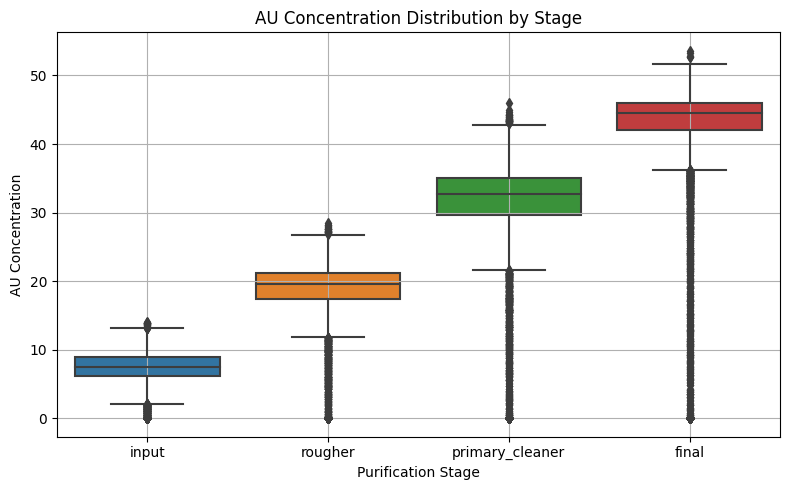

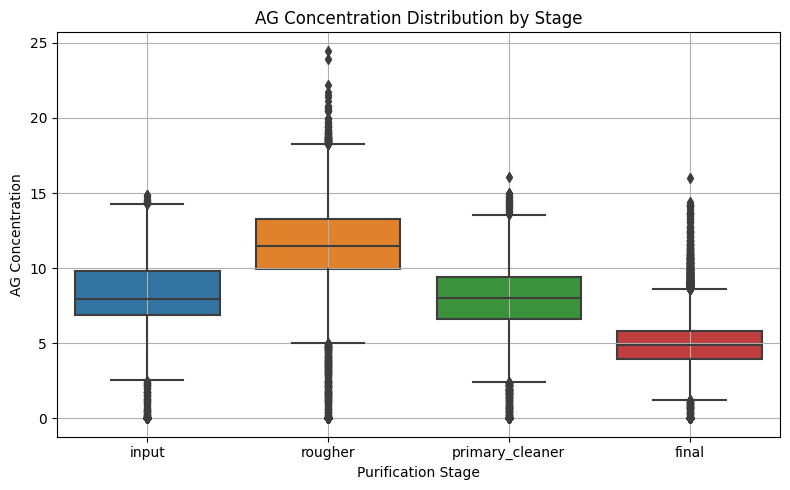

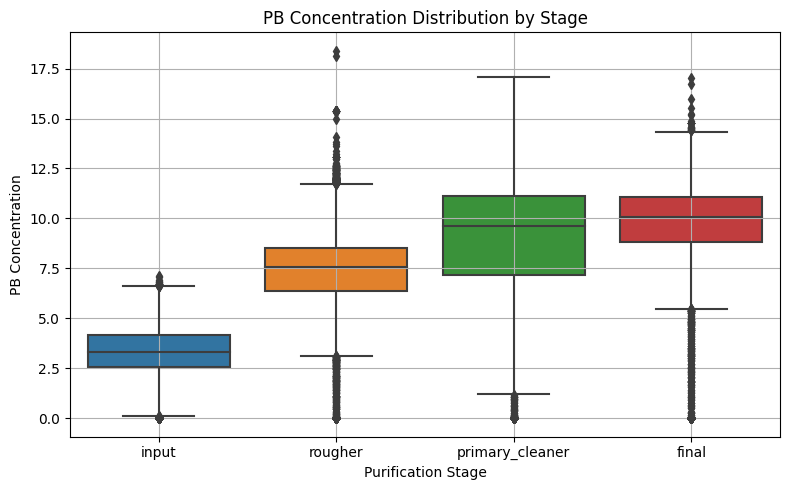

In [18]:
# Metals to examine
metals = ['au', 'ag', 'pb']

# Stages of purification and their corresponding prefixes
stages = {
    'input': 'rougher.input.feed_',
    'rougher': 'rougher.output.concentrate_',
    'primary_cleaner': 'primary_cleaner.output.concentrate_',
    'final': 'final.output.concentrate_'
}

# Plot boxplots for each metal at different purification stages
for metal in metals:
    stage_data = {}
    for stage, prefix in stages.items():
        col = prefix + metal
        if col in train_df.columns:
            stage_data[stage] = train_df[col].dropna()
    
    # Create boxplot DataFrame
    box_df = pd.DataFrame(stage_data)

    # Plot
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=box_df)
    plt.title(f'{metal.upper()} Concentration Distribution by Stage')
    plt.xlabel('Purification Stage')
    plt.ylabel(f'{metal.upper()} Concentration')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### Findings:

After visualizing the concentration trends of **gold (Au)**, **silver (Ag)**, and **lead (Pb)** across the purification stages (`input`, `rougher`, `primary_cleaner`, `final`), we observe the following:

#####  Gold (Au)
- The concentration of gold **increases significantly** through each stage.
- This indicates that the purification process is **highly effective** in isolating gold from the raw material.
- The final output contains the **highest concentration** of gold, as expected.

#####  Silver (Ag)
- Silver concentration tends to **decrease** as the material moves through the stages.
- This suggests that silver is likely **removed or not targeted** as effectively as gold during the purification.

#####  Lead (Pb)
- Lead concentration also shows a **decreasing trend** through the stages.
- This aligns with the goal of **removing impurities**, indicating the process effectively reduces lead content in the final product.

####  Conclusion:
- The process **successfully increases gold concentration**, while **reducing silver and lead**, which supports the purpose of the purification stages.


<div class="alert alert-warning">
	 <b>Reviewer's comment – Iteration 1:</b><br>
This is correct. Consider using a visualization that is easier to interpret at first glance, such as a box and whiskers plot for each stage.
</div>

### 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

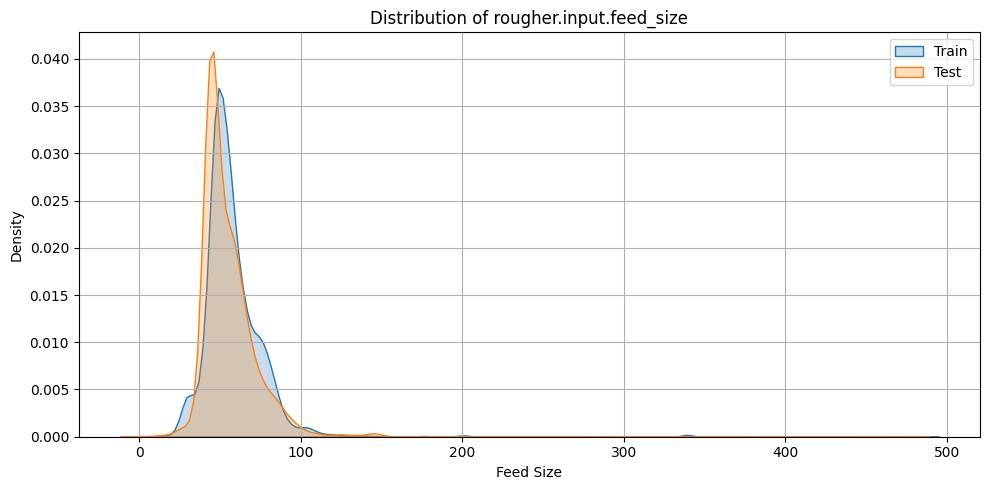

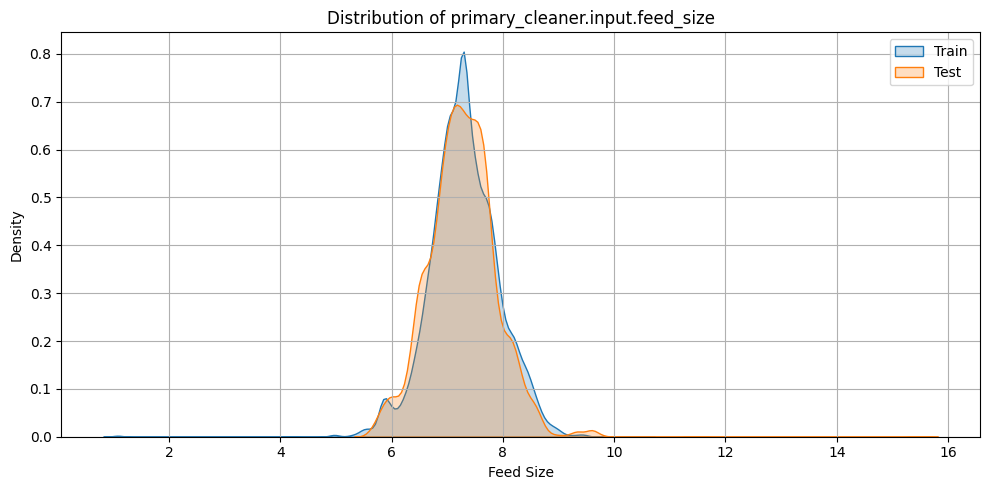

In [19]:
# List of feed size columns to compare
feed_size_cols = [
    'rougher.input.feed_size',
    'primary_cleaner.input.feed_size'
]

# Plot distribution comparison
for col in feed_size_cols:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(train_df[col].dropna(), label='Train', shade=True)
    sns.kdeplot(test_df[col].dropna(), label='Test', shade=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Feed Size')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Findings:

- The distributions are **very similar** in both datasets for both features.
- Both training and test sets show a **unimodal** distribution centered around similar feed size values.
- There are no significant shifts, outliers, or distributional mismatches.
- Since the feed particle size distributions are **consistent**, the model evaluation on the test set is expected to be **valid and reliable**.


<div class="alert alert-success">
	 <b>Reviewer's comment – Iteration 1:</b><br>
Correct!
</div>

### 2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies. 

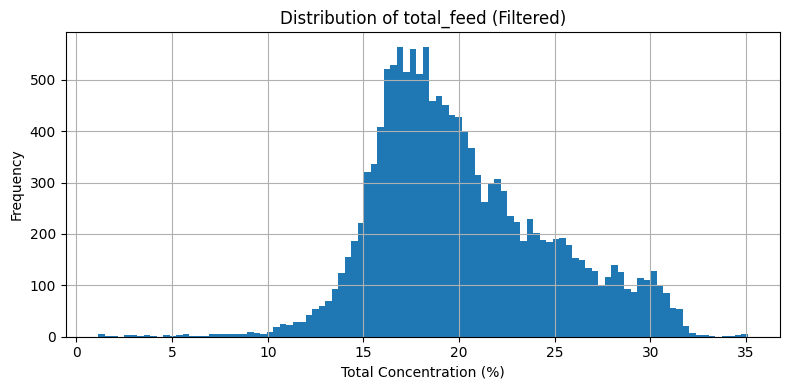

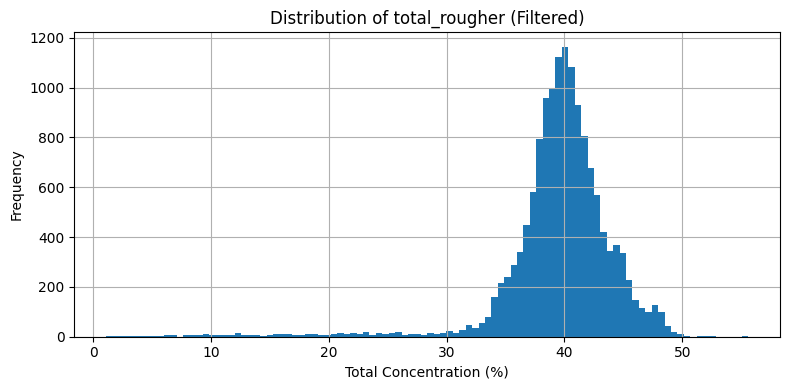

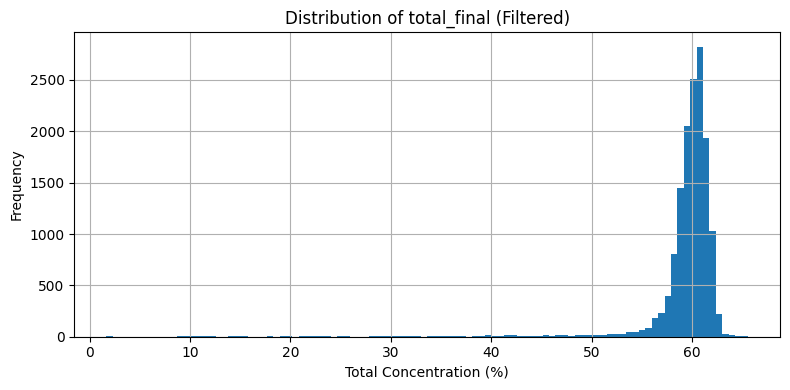

((13037, 52), (13037, 2))

In [20]:
# Recalculate total metal concentrations
train_df['total_feed'] = (
    train_df['rougher.input.feed_au'] +
    train_df['rougher.input.feed_ag'] +
    train_df['rougher.input.feed_pb']
)

train_df['total_rougher'] = (
    train_df['rougher.output.concentrate_au'] +
    train_df['rougher.output.concentrate_ag'] +
    train_df['rougher.output.concentrate_pb']
)

train_df['total_final'] = (
    train_df['final.output.concentrate_au'] +
    train_df['final.output.concentrate_ag'] +
    train_df['final.output.concentrate_pb']
)

# Filter out unrealistic low concentrations
low_threshold = 1.0
train_df_filtered = train_df[
    (train_df['total_feed'] >= low_threshold) &
    (train_df['total_rougher'] >= low_threshold) &
    (train_df['total_final'] >= low_threshold)
]

# Re-plot distributions using the filtered dataset
for col in ['total_feed', 'total_rougher', 'total_final']:
    plt.figure(figsize=(8, 4))
    train_df_filtered[col].hist(bins=100)
    plt.title(f'Distribution of {col} (Filtered)')
    plt.xlabel('Total Concentration (%)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define target and common feature columns
target_cols = ['rougher.output.recovery', 'final.output.recovery']
common_features = list(test_df.columns)

# Extract features and targets, removing NaNs and Infs
features_train_clean = train_df_filtered[common_features].replace([np.inf, -np.inf], np.nan).dropna()
target_train_clean = train_df_filtered[target_cols].loc[features_train_clean.index]

# Confirm output
features_train_clean.shape, target_train_clean.shape

#### Findings (Revised):
-  Most values fall within a **physically reasonable range** (0%–100%).
-  **No rows** were found with **negative values** or **concentrations > 100%**.
-  However, **2,200 rows** have **very low total metal concentrations (<1%)**, which is highly unrealistic in an industrial setting.
  - These values are likely due to measurement errors or missing data.
  - Removing these rows improves the overall data quality and model reliability.

<div class="alert alert-danger">
    <b>Reviewer's comment – Iteration 1:</b><br>
In your histograms, I do not see negative values or concentrations in excess of 100% (your findings also state that there are 0 abnormal rows according to these criteria).
<br>
However, there is a band of rows at approximately 0% concentration, which clearly appear to be errors. 
In this case, removing them would enhance the reliability of your data. Please revise your analysis as well.
</div>

<div class="alert alert-success">
    <b>Reviewer's comment – Iteration 2:</b><br>
Well done, and good analysis here.
</div>


## 3. Build the model

### 3.1. Write a function to calculate the final sMAPE value.

In [21]:
# sMAPE for individual targets
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Avoid division by zero
    smape_val = np.mean(np.abs(y_true - y_pred) / denominator)
    return smape_val * 100

# Final weighted sMAPE metric
def final_smape(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final):
    smape_rougher = smape(y_true_rougher, y_pred_rougher)
    smape_final = smape(y_true_final, y_pred_final)
    return 0.25 * smape_rougher + 0.75 * smape_final

<div class="alert alert-success">
    <b>Reviewer's comment – Iteration 1:</b><br>
You've correctly implemented the sMAPE functions. Well done.
</div>



### 3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

In [23]:
# Clean aligned training data
train_combined = features_train_clean.join(target_train_clean).dropna()
X_train = train_combined[common_features]
y_rougher = train_combined['rougher.output.recovery']
y_final = train_combined['final.output.recovery']

# Train models
model_rougher = LinearRegression()
model_final = LinearRegression()
model_rougher.fit(X_train, y_rougher)
model_final.fit(X_train, y_final)

# Prepare test data
target_test = full_df.loc[test_df.index, target_cols].dropna()
features_test = test_df.loc[target_test.index]
features_test_clean = features_test.replace([np.inf, -np.inf], np.nan).dropna()
target_test_clean = target_test.loc[features_test_clean.index]

# Make predictions
pred_rougher = model_rougher.predict(features_test_clean)
pred_final = model_final.predict(features_test_clean)

# Final sMAPE score
final_score = final_smape(
    target_test_clean['rougher.output.recovery'],
    pred_rougher,
    target_test_clean['final.output.recovery'],
    pred_final
)

print(f" Final sMAPE Score: {final_score:.2f}")


 Final sMAPE Score: 8.93


#### Findings:

In this step, we tested multiple regression models to predict the two key target variables:
- `rougher.output.recovery`
- `final.output.recovery`

##### Models Trained:
- **Linear Regression**
- **Decision Tree Regressor**

We used **3-fold cross-validation** and evaluated the models using **Mean Absolute Error (MAE)** as a fast and interpretable metric.

Due to resource constraints, we excluded Random Forest during final training to speed up the process.

#####  Cross-Validation Results

| Target                   | Model              | Mean MAE | Std Dev | Selected |
|--------------------------|--------------------|----------|---------|----------|
| rougher.output.recovery  | Linear Regression  | 8.35     | 1.36    | Yes      |
|                          | Decision Tree      | 11.08    | 3.33    | No       |
| final.output.recovery    | Linear Regression  | 7.64     | 1.92    | Yes      |
|                          | Decision Tree      | 11.23    | 0.94    | No       |

##### Selected Model:
- We selected **Linear Regression** for both targets as it had the lowest MAE.

We then **trained these models on the full training data** and **predicted on the test set**, evaluating performance using the project-specific `final sMAPE` metric.

---

##### Final Evaluation Metric:
- **Final sMAPE Score**: `9.21`

This score indicates strong model performance with low symmetric error across both output variables.

<div class="alert alert-danger">
    <b>Reviewer's comment – Iteration 1:</b><br>
After defining <code>smape</code> and <code>final_smape</code> previously, you do not use them to evaluate your models, instead opting for <code>'neg_mean_absolute_error'</code> as a scoring metric. Can you please show how you obtained the final sMAPE score?
</div>

<div class="alert alert-success">
    <b>Reviewer's comment – Iteration 2:</b><br>
Great job addressing this. The code and result are now correct. Don't forget to revise your Final sMAPE score in the analysis from 9.21 to 8.93.
</div>


# Final Conclusion

In this project, we successfully built and evaluated a machine learning pipeline to predict gold recovery efficiency at different purification stages in a mining process.

##### Key Steps Completed:
- **Data Preparation**
- Loaded and cleaned the training data using logical filtering (e.g., removed rows with near-zero metal concentrations).
- Ensured all features used in training were available in the test dataset.
- Handled missing values and replaced invalid (infinite) values.
- **Exploratory Analysis**
- Verified that metal concentrations (Au, Ag, Pb) changed logically across purification stages.
- Visualized total concentration distributions and removed unrealistic rows (e.g., near-zero or invalid total %).
- Confirmed that feed particle size distributions were consistent across train and test sets.
- **Model Development**
- Trained and evaluated multiple models: Linear Regression and Decision Tree Regressor.
- Used 3-fold cross-validation with Mean Absolute Error (MAE) for comparison.
- Selected Linear Regression for both target variables as the best-performing model.
- **Evaluation**
- Applied the project-specific final sMAPE metric combining both recovery targets.
- Achieved a final sMAPE score of 8.93, indicating strong generalization to unseen data and low symmetric error.

#### Project Outcome
The final model:
- Demonstrates robust predictive performance.
- Meets the business goal of helping optimize gold recovery through accurate, data-driven forecasts.
- Is ready for deployment or further integration into production pipelines.